In [1]:
import copy
import os
import re

from matplotlib import pyplot as plt
import textgrids
from scipy.io import wavfile
from silence_aligner import extract_segments_from_file
import IPython.display
from jiwer import wer

In [2]:

length_std = {'sil': 0.37004250783970655,
 'g': 0.0970459455376011,
 'a': 0.05660433687030533,
 'f': 0.056929615415985,
 's': 0.10598433935792115,
 'n': 0.044217450983390603,
 'r': 0.025405123070675686,
 'j': 0.06591924956009611,
 'R': 0.0517020847447505,
 'o': 0.060734759874077476,
 'b': 0.06107722854276204,
 'i': 0.04044209198174864,
 'k': 0.09041679558761224,
 'u': 0.050785248251638125,
 'd': 0.053657157384060246,
 'e': 0.04168302088249228,
 'l': 0.05306956815151603,
 'c': 0.08385220938537917,
 'm': 0.05156874573425406,
 't': 0.05078924791058343,
 'p': 0.06496014058103297,
 'y': 0.004456240066948667,
 'C': 0.024831451374519697,
 'N': 0.0,
 '': 0.646766174211673,
 'S': 0.0}

length_avg = {'sil': 0.6619947347517942,
 'g': 0.10168757313538922,
 'a': 0.14216359277803084,
 'f': 0.12765944865075077,
 's': 0.1842492552669475,
 'n': 0.10900618568216998,
 'r': 0.04598977151391705,
 'j': 0.1038708272358285,
 'R': 0.09990348885317477,
 'o': 0.14870062878468995,
 'b': 0.08269588485554184,
 'i': 0.1294199589781047,
 'k': 0.11736411443279583,
 'u': 0.14413120538869068,
 'd': 0.08530152426467356,
 'e': 0.11940625321237626,
 'l': 0.11286410173154132,
 'c': 0.10325003239861755,
 'm': 0.11838473491333955,
 't': 0.07873005754645007,
 'p': 0.06925395812614847,
 'y': 0.11183312549768909,
 'C': 0.12745184747265748,
 'N': 0.05756467874794069,
 '': 0.49404709249643247,
 'S': 0.09273662429796059}

In [3]:
AUDIOS_FOLDER = "cropped_audios"
TRANSCRIPTION_FOLDER = "cropped_annotations"
TEXTS_FOLDER = "texts"
OUTPUT_ALIGN_FOLDER = "phoneme_length_align"

In [219]:
base_file_name = "F_64_1"
os.getcwd()

'/home/ma0/projects/openspeechorg/python-speech-soa/06_alignment'

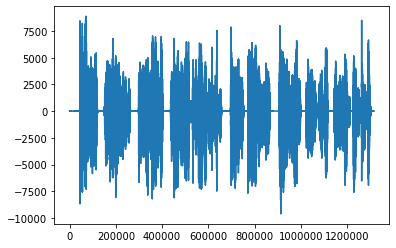

In [220]:
frequency_from_signal, signal = wavfile.read(
    os.path.join(
        AUDIOS_FOLDER,
        f"cropped_{base_file_name}.wav"
    )
)
plt.plot(signal)

In [221]:
IPython.display.Audio(signal, rate=frequency_from_signal)

In [222]:


silences, frequency  = extract_segments_from_file(
    os.path.join(
        AUDIOS_FOLDER,
        f"cropped_{base_file_name}.wav",
    ),
)

Desired threshold, 0.05
277465457.18673486


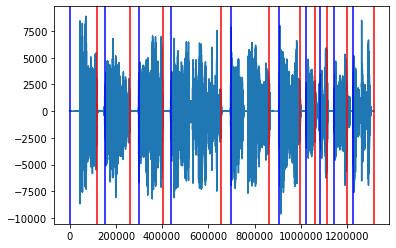

In [223]:

segments = list()
last_start = 0
for start, stop in silences:
    segments.append((last_start, start))
    last_start = stop

segments.append((last_start,signal.shape[-1]))
plt.plot(signal)
for start, stop in segments:
    plt.axvline(start, color="blue")
    plt.axvline(stop, color="red")

In [224]:
def sent_tokenize(text):
    return [x for x in re.split("\.|,|;|:|\n|!|¿|¡|\?|-|—|\(|\)|«|»", text) if x.replace(" ", "")]

with open(
    os.path.join(
        TEXTS_FOLDER,
        f"{base_file_name.replace('cropped_', '')}.txt"
    )) as file:
    text = " ".join(file.readlines())

tokens = sent_tokenize(text)
tokens = tokens[1:]
words_count = len(text.split(" "))

In [225]:
tokens

[' Ojos claros',
 ' serenos',
 ' si de un dulce mirar sois alabados',
 'por qué',
 ' si me miráis',
 ' miráis airados',
 ' Si cuanto más piadosos',
 ' más bellos parecéis a aquel que os mira',
 ' no me miréis con ira',
 ' porque no parezcáis menos hermosos',
 'Ay tormentos rabiosos',
 ' Ojos claros',
 ' serenos',
 ' ya que así me miráis',
 ' miradme al menos']

In [226]:
signal_segment_lengths = [(stop-start)/frequency for start, stop in segments]

In [227]:

sum(signal_segment_lengths)

23.094716553287984

In [228]:
remap = {
    "z": "s",
    "v": "b",
    "q": "k",
    "ñ": "N",
    "h": "",
    "ó": "o",
    "á": "a",
    "é": "e",
    "í": "i",
    "ú": "u",
    "x": "s"
}

def calculate_token_lengths(text):
    partial_times = list()
    partial_std = list()
    for letter in text:
        letter = remap.get(letter, letter).strip().lower()
        if letter in length_avg:
            partial_times.append(length_avg[letter])
            partial_std.append(length_std[letter])
        else:
            print(f"Letter not found {letter}")
    return sum(partial_times), sum(partial_std)

expected_token_lengths = [calculate_token_lengths(text) for text in tokens]

In [229]:
sum([x[0] for x in expected_token_lengths])

55.53699548352951

In [230]:

len(expected_token_lengths)

15

In [231]:

len(signal_segment_lengths)

10

In [232]:
len(tokens)

15

In [233]:
def safe_access(arr, i):
    return arr[i] if i < len(arr) else ""

for i in range(max(len(expected_token_lengths), len(signal_segment_lengths), len(tokens))):
    print(safe_access(tokens, i), safe_access(signal_segment_lengths, i), safe_access(expected_token_lengths, i))


 Ojos claros 2.64 (2.310832907538765, 1.9725557937993934)
 serenos 2.42 (1.405054695435857, 1.0724582286206437)
 si de un dulce mirar sois alabados 2.35 (6.963666248495377, 6.164086747598626)
por qué 4.91 (1.1388930239550508, 0.9807512624592019)
 si me miráis 3.81 (2.78322875228851, 2.5004234495880886)
 miráis airados 2.01 (2.615709781785704, 2.0134112228290935)
 Si cuanto más piadosos 0.85 (4.5526756720179815, 3.8437337287053612)
 más bellos parecéis a aquel que os mira 0.71 (7.998995999589296, 7.09730735185279)
 no me miréis con ira 1.32 (4.371133368073059, 4.048816233706996)
 porque no parezcáis menos hermosos 2.0747165532879817 (6.6164085568256255, 5.657337687716371)
Ay tormentos rabiosos  (3.3401574527484845, 2.363466599888145)
 Ojos claros  (2.310832907538765, 1.9725557937993934)
 serenos  (1.405054695435857, 1.0724582286206437)
 ya que así me miráis  (4.548384821368988, 4.094505776540736)
 miradme al menos  (3.175966600432174, 2.6750899661467664)


In [234]:

EXPECTED_TOKEN_LENGTH = expected_token_lengths
# EXPECTED_TOKEN_LENGTH = [(1,0), (1,0), (1,0), (2,0)]
EXPECTED_TOKEN_LENGTH

[(2.310832907538765, 1.9725557937993934),
 (1.405054695435857, 1.0724582286206437),
 (6.963666248495377, 6.164086747598626),
 (1.1388930239550508, 0.9807512624592019),
 (2.78322875228851, 2.5004234495880886),
 (2.615709781785704, 2.0134112228290935),
 (4.5526756720179815, 3.8437337287053612),
 (7.998995999589296, 7.09730735185279),
 (4.371133368073059, 4.048816233706996),
 (6.6164085568256255, 5.657337687716371),
 (3.3401574527484845, 2.363466599888145),
 (2.310832907538765, 1.9725557937993934),
 (1.405054695435857, 1.0724582286206437),
 (4.548384821368988, 4.094505776540736),
 (3.175966600432174, 2.6750899661467664)]

In [235]:
len(EXPECTED_TOKEN_LENGTH)

15

In [236]:
SIGNAL_SEGMENT_LENGTHS = signal_segment_lengths
# SIGNAL_SEGMENT_LENGTHS = [1,2,1,1]
signal_segment_lengths

[2.64, 2.42, 2.35, 4.91, 3.81, 2.01, 0.85, 0.71, 1.32, 2.0747165532879817]

In [237]:
len(SIGNAL_SEGMENT_LENGTHS)

10

In [238]:
expected_signal_ratio = sum([x[0] for x in EXPECTED_TOKEN_LENGTH]) / sum(SIGNAL_SEGMENT_LENGTHS)
expected_signal_ratio

2.404748954393326

In [239]:
evaluation_stack = [(list(), 0, 0)]

In [240]:
def evaluate_experiment(current_result, expected_index, segment_index, debug=False):
    while expected_index < len(EXPECTED_TOKEN_LENGTH) and segment_index < len(SIGNAL_SEGMENT_LENGTHS):
        expected_avg, expected_std = EXPECTED_TOKEN_LENGTH[expected_index]
        expected_avg = expected_avg / expected_signal_ratio
        expected_std =  0 * expected_std
        segment_length = SIGNAL_SEGMENT_LENGTHS[segment_index]
        if expected_avg - expected_std <= segment_length <= expected_avg + expected_std:
            if debug:
                print("Segment in range expected")
            current_result.append([[expected_index], [segment_index]])
            expected_index += 1
            segment_index += 1
        elif segment_length < expected_avg - expected_std:
            if debug:
                print("Segment too short")
                print(segment_length, expected_avg - expected_std)
            cum_length = segment_length
            cum_index = [segment_index]
            segment_index += 1
            while cum_length < expected_avg - expected_std and segment_index < len(SIGNAL_SEGMENT_LENGTHS):
                if debug:
                    print("Appending", expected_index + 1, segment_index )
                copy_current_result = copy.deepcopy(current_result)
                copy_current_result.append([[expected_index], [segment_index - 1]])
                evaluation_stack.append((copy_current_result, expected_index + 1, segment_index ))
                cum_length += SIGNAL_SEGMENT_LENGTHS[segment_index]
                cum_index.append(segment_index)
                segment_index += 1
            current_result.append([[expected_index], cum_index])
            expected_index += 1
        else:
            if debug:
                print("Segment too long")
                print(segment_length, expected_avg - expected_std)
            cum_length = expected_avg
            cum_index = [expected_index]
            expected_index += 1
            while cum_length < segment_length and expected_index < len(EXPECTED_TOKEN_LENGTH):
                if debug:
                    print("Appending", expected_index, segment_index + 1)
                copy_current_result = copy.deepcopy(current_result)
                copy_current_result.append([[expected_index - 1], [segment_index]])
                evaluation_stack.append((copy_current_result, expected_index, segment_index + 1))
                cum_length += EXPECTED_TOKEN_LENGTH[expected_index][0]
                cum_index.append(expected_index)
                expected_index += 1
            current_result.append([cum_index, [segment_index]])
            segment_index += 1
    return current_result

# result = evaluate_experiment(list(), 0, 0)

In [241]:
possible_results = list()

MAX_ITERS = 10000
i = 0
while evaluation_stack and i<MAX_ITERS:
    i += 1
    # print("SIZE OF THE STACK", len(evaluation_stack))
    current_experiment = evaluation_stack.pop(0)
    # print(current_experiment[0][-1] if len(current_experiment[0]) > 1 else current_experiment[0], current_experiment[1], current_experiment[2])
    possible_results.append(evaluate_experiment(current_experiment[0], current_experiment[1], current_experiment[2]))

print("Final i", i)


Final i 898


In [242]:
def evaluate_result(result_array):
    # return (len(EXPECTED_TOKEN_LENGTH) - 1 - result_array[-1][0][-1]) + (len(SIGNAL_SEGMENT_LENGTHS) - 1 - result_array[-1][1][-1])
    partial_results = 0
    for calculated_segment_length_list, actual_segment_length_list in result_array:
        partial_results += abs(
            sum(EXPECTED_TOKEN_LENGTH[x][0]/expected_signal_ratio for x in calculated_segment_length_list) -
            sum(SIGNAL_SEGMENT_LENGTHS[x] for x in actual_segment_length_list)
        )
    return partial_results

def evaluate_all_results(possible_results):
    return_list = list()
    for index, result_list in enumerate(possible_results):
        return_list.append((index, evaluate_result(result_list)))
    return return_list
evaluation_results = evaluate_all_results(possible_results)
min(evaluation_results, key=lambda x: x[1])

(46, 5.43227850335015)

In [243]:
all_min_values = list(filter(lambda x: x[1] == min(evaluation_results, key=lambda x: x[1])[1], evaluation_results))
all_min_values

[(46, 5.43227850335015)]

In [244]:
for min_value in all_min_values:
    print(possible_results[min_value[0]])
    print("-----")

[[[0, 1, 2], [0]], [[3, 4], [1]], [[5, 6], [2]], [[7, 8], [3]], [[9, 10], [4]], [[11, 12], [5]], [[13], [7]], [[14], [8]]]
-----


In [245]:
first_min_value = all_min_values[0]
first_min_value

(46, 5.43227850335015)

In [246]:
first_min_value_index = first_min_value[0]
first_min_value_index

46

In [247]:
min_value_selected = possible_results[first_min_value_index]
min_value_selected

[[[0, 1, 2], [0]],
 [[3, 4], [1]],
 [[5, 6], [2]],
 [[7, 8], [3]],
 [[9, 10], [4]],
 [[11, 12], [5]],
 [[13], [7]],
 [[14], [8]]]

In [248]:

alignment = list()


for calculated_segment_length_list, actual_segment_length_list in min_value_selected:
    print(actual_segment_length_list)
    alignment.append(
        {
            "text": ' '.join([tokens[x] for x in calculated_segment_length_list]),
            "xmin":  segments[actual_segment_length_list[0]][0]/frequency,
            "xmax":  segments[actual_segment_length_list[-1]][1]/frequency

        }
    )

alignment

[0]
[1]
[2]
[3]
[4]
[5]
[7]
[8]


[{'text': ' Ojos claros  serenos  si de un dulce mirar sois alabados',
  'xmin': 0.0,
  'xmax': 2.64},
 {'text': 'por qué  si me miráis', 'xmin': 3.5, 'xmax': 5.92},
 {'text': ' miráis airados  Si cuanto más piadosos',
  'xmin': 6.76,
  'xmax': 9.11},
 {'text': ' más bellos parecéis a aquel que os mira  no me miréis con ira',
  'xmin': 9.92,
  'xmax': 14.83},
 {'text': ' porque no parezcáis menos hermosos Ay tormentos rabiosos',
  'xmin': 15.78,
  'xmax': 19.59},
 {'text': ' Ojos claros  serenos', 'xmin': 20.57, 'xmax': 22.58},
 {'text': ' ya que así me miráis', 'xmin': 24.57, 'xmax': 25.28},
 {'text': ' miradme al menos', 'xmin': 25.92, 'xmax': 27.24}]

In [249]:
min_value_selected

[[[0, 1, 2], [0]],
 [[3, 4], [1]],
 [[5, 6], [2]],
 [[7, 8], [3]],
 [[9, 10], [4]],
 [[11, 12], [5]],
 [[13], [7]],
 [[14], [8]]]

In [250]:

tg = textgrids.TextGrid()
tg.xmin = 0
tg.xmax = silences[-1][1] / frequency
tier = textgrids.Tier()
tg[base_file_name] = tier

for align in alignment:
    tier.append(
        textgrids.Interval(
            align["text"],
            align["xmin"],
            align["xmax"]
        )
    )

tg.write(
    os.path.join(
            OUTPUT_ALIGN_FOLDER,
            f"{base_file_name}_generated_phoneme_length.TextGrid"
        )
)

In [251]:

transcription_from_annotated_recording = textgrids.TextGrid(
    os.path.join(
        TRANSCRIPTION_FOLDER,
        f"cropped_{base_file_name}.TextGrid"
    )
)

intervals_from_annotated_recording = transcription_from_annotated_recording[base_file_name.replace("cropped_", "")]

In [252]:

wer_list = list()

current_annotation_index = 0
current_interval_index = 0
while current_interval_index < len(intervals_from_annotated_recording):
    try:
        interval = intervals_from_annotated_recording[current_interval_index]
        t_text = interval.text
        t_min = interval.xmin
        t_max = interval.xmax

        a_text = alignment[current_annotation_index]["text"]
        a_min = alignment[current_annotation_index]["xmin"]
        a_xmax = alignment[current_annotation_index]["xmax"]

        if a_xmax < t_max + 1:
            print("Match: ", a_xmax, t_max + 1,)
            try:
                wer_list.append((tokens[int(t_text)-1], a_text))
            except ValueError:
                print("Skipping last??")
        else:
            print("Not Match", a_xmax, t_max + 1,)
            interval_to_append = [t_text]

            while not a_xmax < t_max + 1:
                print("trying next", a_xmax, t_max + 0.5)
                current_interval_index += 1
                interval = intervals_from_annotated_recording[current_interval_index]
                t_text = interval.text
                t_min = interval.xmin
                t_max = interval.xmax
                interval_to_append.append(t_text)
            value_to_append = list()
            for i in interval_to_append:
                try:
                    value_to_append.append(tokens[int(i)-1])
                except ValueError:
                    print("Error decoding", i)
            wer_list.append(("".join(value_to_append), a_text))


        current_interval_index += 1
        current_annotation_index += 1
    except IndexError:
        print("Exiting on index current_interval_index", current_interval_index, "current_annotation_index", current_annotation_index)
        break

Match:  2.64 2.8273469387755092
Not Match 5.92 3.573628117913831
trying next 5.92 3.073628117913831
Not Match 9.11 8.216054421768703
trying next 9.11 7.716054421768703
trying next 9.11 8.463197278911558
Not Match 14.83 12.789773242630382
trying next 14.83 12.289773242630382
Not Match 19.59 18.258095238095237
trying next 19.59 17.758095238095237
Match:  22.58 23.64678004535147
Not Match 25.28 25.110793650793646
trying next 25.28 24.610793650793646
Match:  27.24 28.542585034013598
Exiting on index current_interval_index 14 current_annotation_index 8


In [253]:
wer_list

[(' Ojos claros', ' Ojos claros  serenos  si de un dulce mirar sois alabados'),
 (' serenos si de un dulce mirar sois alabados', 'por qué  si me miráis'),
 ('por qué si me miráis miráis airados',
  ' miráis airados  Si cuanto más piadosos'),
 (' Si cuanto más piadosos más bellos parecéis a aquel que os mira',
  ' más bellos parecéis a aquel que os mira  no me miréis con ira'),
 (' no me miréis con ira porque no parezcáis menos hermosos',
  ' porque no parezcáis menos hermosos Ay tormentos rabiosos'),
 ('Ay tormentos rabiosos', ' Ojos claros  serenos'),
 (' Ojos claros serenos', ' ya que así me miráis'),
 (' ya que así me miráis', ' miradme al menos')]

In [254]:

wer_values = list()
for x in wer_list:
    true_value = x[0].split()
    inferred_value = x[1].split()
    local_wer = wer(true_value, inferred_value)
    percentaje = len(true_value)/ words_count
    print(true_value)
    print(inferred_value)
    print(local_wer)
    print(percentaje)
    wer_values.append(local_wer * percentaje)

wer_values

['Ojos', 'claros']
['Ojos', 'claros', 'serenos', 'si', 'de', 'un', 'dulce', 'mirar', 'sois', 'alabados']
4.0
0.037037037037037035
['serenos', 'si', 'de', 'un', 'dulce', 'mirar', 'sois', 'alabados']
['por', 'qué', 'si', 'me', 'miráis']
1.0
0.14814814814814814
['por', 'qué', 'si', 'me', 'miráis', 'miráis', 'airados']
['miráis', 'airados', 'Si', 'cuanto', 'más', 'piadosos']
1.0
0.12962962962962962
['Si', 'cuanto', 'más', 'piadosos', 'más', 'bellos', 'parecéis', 'a', 'aquel', 'que', 'os', 'mira']
['más', 'bellos', 'parecéis', 'a', 'aquel', 'que', 'os', 'mira', 'no', 'me', 'miréis', 'con', 'ira']
0.75
0.2222222222222222
['no', 'me', 'miréis', 'con', 'ira', 'porque', 'no', 'parezcáis', 'menos', 'hermosos']
['porque', 'no', 'parezcáis', 'menos', 'hermosos', 'Ay', 'tormentos', 'rabiosos']
0.8
0.18518518518518517
['Ay', 'tormentos', 'rabiosos']
['Ojos', 'claros', 'serenos']
1.0
0.05555555555555555
['Ojos', 'claros', 'serenos']
['ya', 'que', 'así', 'me', 'miráis']
1.6666666666666667
0.0555555555

[0.14814814814814814,
 0.14814814814814814,
 0.12962962962962962,
 0.16666666666666666,
 0.14814814814814814,
 0.05555555555555555,
 0.09259259259259259,
 0.09259259259259259]

In [255]:
total_wer = sum(wer_values)
total_wer * 100

98.14814814814814

# UNUSED BELOW


In [ ]:
tg = textgrids.TextGrid()
tg.xmin = 0
tg.xmax = silences[-1][1] / frequency
tier = textgrids.Tier()
tg[base_file_name] = tier

index_time = 0
index_text = 0
time = 0

annotation = ""
time_index = 0
for i, (expected_time, std) in enumerate(expected_token_lengths):
    try:
        if expected_time - std < signal_segment_lengths[time_index] < expected_time + std:
            # Correspondencia
            print("First one")
            tier.append(
                    textgrids.Interval(
                        tokens[i],
                        segments[time_index][0]/frequency,
                        segments[time_index][1]/frequency
                    )
                )
            time_index += 1
            time += signal_segment_lengths[time_index]
        elif expected_time - std >  signal_segment_lengths[time_index]:
            print("Second one")
            # Misma anotacion multiples segmentos
            accum_time = signal_segment_lengths[time_index]
            start_index = time_index
            while expected_time - std > accum_time:
                time_index += 1
                accum_time += signal_segment_lengths[time_index]
            end_index = time_index
            tier.append(
                    textgrids.Interval(
                        tokens[i],
                        segments[start_index][0]/frequency,
                        segments[end_index][1]/frequency
                    )
                )
            time += accum_time
            print(time_index)
    except IndexError:
        print("O'o nos pasamos")
        break
tg.write(f"{base_file_name}_generated.TextGrid")

In [ ]:
enum = enumerate(expected_token_lengths)
time_index = 0

In [ ]:
i, (expected_time, std) = next(enum)
std = std / 2

In [ ]:
start = int(segments[time_index][0])
stop = int(segments[time_index][1])
wave = signal[start: stop]

IPython.display.Audio(wave, rate=frequency)


In [ ]:
plt.plot(signal)

plt.axvline(start, color="blue")
plt.axvline(stop, color="red")

In [ ]:
tokens[i]


In [ ]:
expected_time - std < signal_segment_lengths[time_index] < expected_time + std

In [ ]:
print(expected_time)
print(std)
print(signal_segment_lengths[time_index])
expected_time - std

In [ ]:

if expected_time - std < signal_segment_lengths[time_index] < expected_time + std:
    # Correspondencia
    print("First one")
    tier.append(
            textgrids.Interval(
                tokens[i],
                segments[time_index][0]/frequency,
                segments[time_index][1]/frequency
            )
        )
    time_index += 1
    time += signal_segment_lengths[time_index]
elif expected_time - std >  signal_segment_lengths[time_index]:
    print("Second one")
    # Misma anotacion multiples segmentos
    accum_time = signal_segment_lengths[time_index]
    start_index = time_index
    while expected_time - std > accum_time:
        time_index += 1
        accum_time += signal_segment_lengths[time_index]
    end_index = time_index
    tier.append(
            textgrids.Interval(
                tokens[i],
                segments[start_index][0]/frequency,
                segments[end_index][1]/frequency
            )
        )
    time += accum_time
    print(time_index)